In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
import sklearn.model_selection as CrossValidate
from matplotlib.pyplot import rcParams


plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from patsy import dmatrices
import statsmodels.api as sm


print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.2.0
Eager execution: True


In [2]:
## Define Poisson loss and gradient

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    logits = model(x, training=training)

    return tf.keras.losses.poisson(y,logits)


## Gradient tape lets TF know with respect to what to take gradients
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [22]:
#standardizer function which standardizes the numerical data and encodes the categorical data with One hot encoding
def standardize_fit2 (Xin):
    #standadizing the numercial values
    scaler = StandardScaler()
    X = Xin.values[:,1:4]
    scaler.fit(X)

    #standadizing the categorical values
    encoder = OneHotEncoder(sparse=False)
    X = Xin.values[:,0].reshape(-1, 1)
    encoder.fit(X)
    categories= encoder.categories_

    return categories, scaler, encoder 

def standardize_transfrom2( Xin, scaler, encoder):
    X = Xin.values[:,1:4]
    X_std_num = np.asarray(scaler.transform(X)).astype(np.float64)
    X = Xin.values[:,0].reshape(-1, 1)
    X_std_cat =  encoder.transform(X)
    return np.concatenate((X_std_cat, X_std_num),axis=1)

In [44]:
#importing the train set
X_tr = pd.read_csv('../data/X_weekly_tr.csv')   
y_tr = pd.read_csv('../data/y_weekly_change_tr.csv') 
print(X_tr.shape)
print(y_tr.shape)

#importing the test set
X_te = pd.read_csv('../data/X_weekly_te.csv')   
y_te = pd.read_csv('../data/y_weekly_change_te.csv') 
print(X_te.shape)
print(y_te.shape)

(436, 6)
(436, 2)
(104, 6)
(104, 2)


In [45]:
train_timestamps = X_tr['Date'].values
test_timestamps = X_te['Date'].values

In [46]:
X_tr = X_tr.drop(['Date'], axis=1)
y_tr = y_tr.drop(['Date'], axis=1)
X_te = X_te.drop(['Date'], axis=1)
y_te = y_te.drop(['Date'], axis=1)

In [47]:
# just to make sure if any Null is left
print ("number of nulls left is ", len(X_tr[X_tr.isnull().values == True].head()))
print ("number of nulls left is ", len(X_te[X_te.isnull().values == True].head()))

number of nulls left is  0
number of nulls left is  0


In [60]:
#X_tr = X_tr.reset_index()
X_tr.head()

,Province_State,Weekly_Avg_Pct_Home,Elapsed_Days,Incident_Rate_Last_week,Incident_Rate_Pct_Change_Last_week
0,Arizona,27.624795,0,0.013739,0.0
1,Illinois,25.986911,0,0.015783,1.0
2,California,25.540295,0,0.007593,0.5
3,Washington,27.401260,0,0.013132,0.0
4,California,23.975602,0,0.015185,1.0


In [49]:
#standardizing the test data from the previously fitted standardizers
#X_te_std1 = standardize_transfrom1(X_te, scaler, encoder1)
categories, scaler, encoder2 = standardize_fit2(X_te)
X_te_std2 = standardize_transfrom2(X_te, scaler, encoder2)
categories, scaler, encoder2 = standardize_fit2(X_tr)
X_tr_std2 = standardize_transfrom2(X_tr, scaler, encoder2)
# using the standardized data with sparse matrix for the categorized data (One hot encoded)
X_te_std = X_te_std2
X_tr_std = X_tr_std2
print(X_te_std.shape)
print(X_tr_std.shape)

(104, 55)
(436, 55)


In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_std,y_tr))
test_dataset = tf.data.Dataset.from_tensor_slices((X_te_std,y_te))

batch_size = 32

#train_dataset_house = train_dataset_house.shuffle(buffer_size=len(X_tr))
train_dataset = train_dataset.batch(batch_size)
#test_dataset_house = test_dataset_house.shuffle(buffer_size=len(X_te))
test_dataset= test_dataset.batch(batch_size)

In [52]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(64,activation="sigmoid"), 
  tf.keras.layers.Dense(32,activation="sigmoid"), 
  tf.keras.layers.Dense(1, activation='relu')
])

In [53]:
logits = model(X_tr_std)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  3584      
_________________________________________________________________
dense_4 (Dense)              multiple                  2080      
_________________________________________________________________
dense_5 (Dense)              multiple                  33        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [54]:
## Training Model
train_loss_results = []
train_accuracy_results = []
num_epochs = 1000


optimizer = tf.keras.optimizers.Adam()

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.MeanAbsoluteError()
    
    # Training loop - using batches of 32
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))       

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        epoch_accuracy.update_state(y, model(x, training=True))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 100 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))



Epoch 000: Loss: 1.226
Epoch 100: Loss: -0.023
Epoch 200: Loss: -0.172
Epoch 300: Loss: -0.238
Epoch 400: Loss: -0.261
Epoch 500: Loss: -0.292
Epoch 600: Loss: -0.353
Epoch 700: Loss: -0.389
Epoch 800: Loss: -0.415
Epoch 900: Loss: -0.430


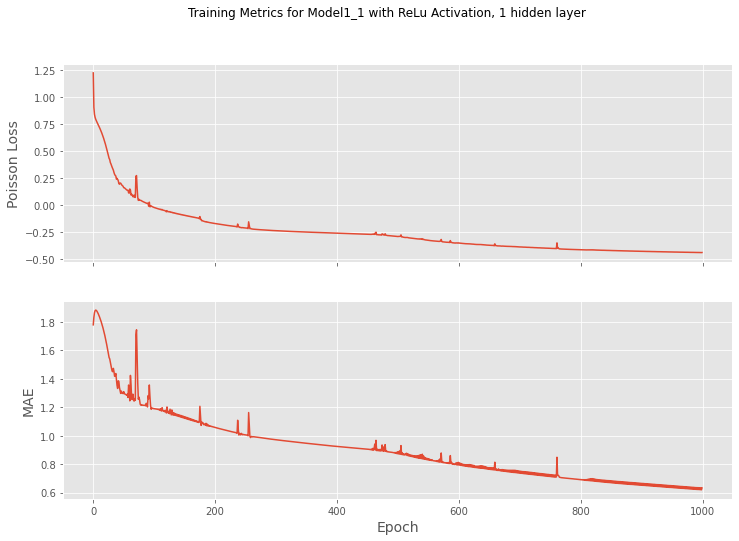

In [55]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics for Model1_1 with ReLu Activation, 1 hidden layer')

axes[0].set_ylabel("Poisson Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("MAE", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [56]:
## Compute test loss
test_loss_results = []
test_accuracy_results = []

test_loss_avg = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.MeanAbsoluteError()
for (x, y) in test_dataset:
    # training=False is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout). = 
    y_pred = model(x, training=False)
    test_loss_avg.update_state(loss(model, x, y, training=False))
    test_accuracy.update_state(y, model(x, training=False))
test_loss_results.append(test_loss_avg.result())
test_accuracy_results.append(test_accuracy.result())


In [57]:
print("Test set MAE Model{:01d}: {:.5}".format(1,test_accuracy_results[0]))
print("Test set Poisson Loss Model{:01d}: {:.5}".format(1,test_loss_results[0]))

Test set MAE Model1: 0.97516
Test set Poisson Loss Model1: 1.1468
